In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import re
from xgboost import XGBClassifier
import chess.pgn
import io
from stockfish import Stockfish

In [8]:
df=pd.read_csv('games.csv')


In [9]:
game = chess.pgn.read_game(io.StringIO(df['moves'][1])) #parse each pgn string
print(game.mainline_moves())

1. d4 Nc6 2. e4 e5 3. f4 f6 4. dxe5 fxe5 5. fxe5 Nxe5 6. Qd4 Nc6 7. Qe5+ Nxe5 8. c4 Bb4+


Using the Chess module, we can parse the string of moves for each game into a format readable by Stockfish. We will aim to create a function that extracts and then evaluates the state of a game at a particular move number, or node

In [65]:
#extract the nth node of a pgn string as a linked list
def get_nth_node(self, n):
    current=game
    count = 0

    while current:
        if count == n:
            return current
        count += 1
        current = current.next()

In [67]:
#stockfish parameters - depth can be adjusted here to increase precision of evaluation
stockfish = Stockfish(path="/stockfish/stockfish-windows-x86-64-avx2.exe", depth=18, parameters={"Threads": 2, "Minimum Thinking Time": 30})

The stockfish get_evaluation method will return the valuation for a given game state. To start, we will be evaluating each game at its halfway point. In the future it may be worth looking into evaluations at different points during the match, but generally states at the very begginging or ends of the match will be less interesting and likely less informative for our model.  

This is an example of what this will look like, along with a visual representation of the board at the state in time. In this case, the match is evaluated to be a forced checkmate in 6 moves. For other games, type will be "cp", which indicates that stockfish has not identified a forced checkmate, and is instead producting a calculated evaluation in centipawn units (equal to the approximate advantage of 1/100 of a pawn). Note that decision tree based models such as XGBoost will be robust to the conditional nature of this variable, but in order to train other models such as a logistic regression we would need to split it into two 

In [68]:
game = chess.pgn.read_game(io.StringIO(df['moves'][2])) #parse pgn string

game_node = get_nth_node(game,int(df['turns'][2]/2))
board=game_node.board()
pos = board.fen(en_passant='fen') #grab fen string of current position
stockfish.set_fen_position(pos)
eval=stockfish.get_evaluation()
print(board)
print((eval['type'], eval['value']))

. . . . k b n r
. . . . . p p p
. . P . b . . .
. . . P p . . .
. . . . . . . .
R . P . B . . .
. P . . B P P P
. . . Q K . N R
('mate', 8)


In [66]:
#get stockfish evaluation for each row in dataset
df2=[]
for index,row in df.iterrows():
    game = chess.pgn.read_game(io.StringIO(df['moves'][index])) 
    game_node = get_nth_node(game,int(df['turns'][index]/2))
    board=game_node.board()
    pos = board.fen(en_passant='fen') #grab fen string of current position
    stockfish.set_fen_position(pos)
    eval=stockfish.get_evaluation()
    df2.append((df['id'][index],eval['type'], eval['value'] ))


In [52]:
df2=pd.DataFrame(df2,columns=('id','end_type','cp_loss'))
df2=df2.set_index('id')

In [62]:
df2.head()

,end_type,cp_loss
id,,
TZJHLljE,cp,170
l1NXvwaE,cp,80
mIICvQHh,mate,11
kWKvrqYL,cp,1057
9tXo1AUZ,cp,622


In [57]:
#Load dataframe from "chess.ipynb" for creating models
df1=pd.read_csv(r'C:\Users\andwr\Documents\code_outputs\chess\chess_preprocessed1.csv')

In [58]:
#Join match evaluations to initial dataframe
#Left join will remove rows for games that end in draws since these were removed from df1
df1=df1.set_index('id')
df3=df1.join(df2, on='id', how='left')
df3.reset_index(drop=True,inplace=True)

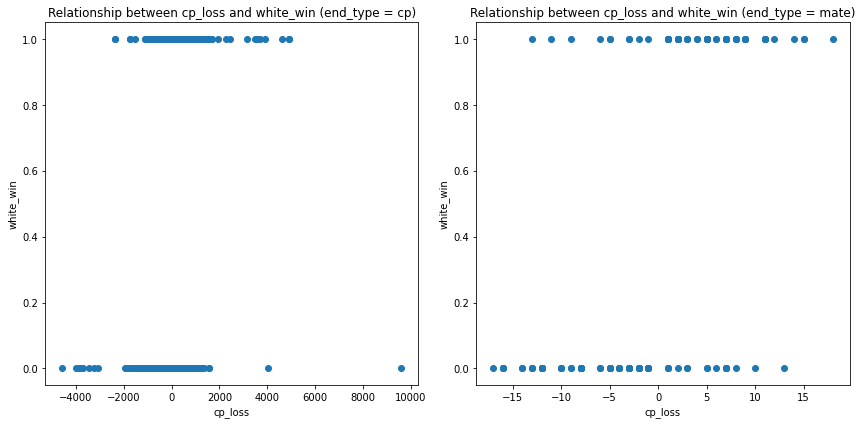

In [72]:
#Plot relationship between match winner and stockfish evaluation, boken out by evaluation type
plt.figure(figsize=(12, 6))

value1='cp'
value2='mate'

# First subplot for the first value of var3
plt.subplot(1, 2, 1)
plt.scatter(df3[df3['end_type'] == value1]['cp_loss'], df3[df3['end_type'] == value1]['white_win'])
plt.title(f'Relationship between cp_loss and white_win (end_type = {value1})')
plt.xlabel('cp_loss')
plt.ylabel('white_win')

# Second subplot for the second value of var3
plt.subplot(1, 2, 2)
plt.scatter(df3[df3['end_type'] == value2]['cp_loss'], df3[df3['end_type'] == value2]['white_win'])
plt.title(f'Relationship between cp_loss and white_win (end_type = {value2})')
plt.xlabel('cp_loss')
plt.ylabel('white_win')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


Based on this visualization, there is at least some relationship between the midpoint stockfish evaluation and the ultimate winner of the match. We will now look into how this adds to our ability to make a prediction about the winner in addition to the initial features used.

In [60]:
#Perfrom same encoding and test split as before
enc = OneHotEncoder()
df3_enc= enc.fit_transform(df3[['opening_group','rated','victory_status','end_type']])
df3_enc=pd.DataFrame(df3_enc.toarray(),columns=enc.get_feature_names_out())
df3=pd.concat([df3,df3_enc],axis=1)
cols=['rating_diff','white_rating','turns','game_length','increment','cp_loss']
enc_cols=[i for i in enc.get_feature_names_out()]
cols.extend(enc_cols)
X_train, X_test, y_train, y_test = train_test_split(df3[cols], df3.white_win, test_size=0.25, random_state=0)

In [61]:
#Create a Gradient boosted tree model using XGBoost using GridSearchCV to find optimal hyperparameters
xgb = XGBClassifier()

param_grid = {
    'max_depth': [3, 5, 8, 13],              
    'min_child_weight': [1, 3, 5, 7],         
    'gamma': [0, 0.1, 1],               
    'subsample': [0.8, 0.9],              
    'colsample_bytree': [0.8, 0.9]       
}

grid_search = GridSearchCV(xgb, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_xgb_model = grid_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)

train_score=best_xgb_model.score(X_train, y_train)
test_score=best_xgb_model.score(X_test, y_test)

print(f"XGBoost Training Accuracy: {train_score:.2f}%")
print(f"XGBoost Test Accuracy: {test_score:.2f}%")

XGBoost Training Accuracy: 0.96%
XGBoost Test Accuracy: 0.88%


In [63]:
# Get feature importance scores of the model
feature_scores = best_xgb_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_scores})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance.head(10))

                                Feature  Importance
5                               cp_loss    0.046380
2                                 turns    0.040099
0                           rating_diff    0.030123
63   opening_group_King's Indian Attack    0.029142
137            victory_status_outoftime    0.026980
26            opening_group_Center Game    0.024508
56            opening_group_Indian Game    0.024323
100     opening_group_Queen's Pawn Game    0.024130
139                         end_type_cp    0.023074
112           opening_group_Scotch Game    0.021520


Adding in the stockfish evaluation at the midaway point of each gamne allows us to create a significantly more accurate model. cp_loss ends up being the most important variable under this importance measure. To further understand its importance in the model, we can use SHAP to provide a game-theoretic measure of its contribution.